## Script de création de graphe
cf base de donnée CAIDA : https://publicdata.caida.org/datasets/as-relationships/serial-2/


**README :**
 
The as-rel file contain p2p and p2c relationships.
The format is:

`<provider-as>|<customer-as>|-1` <br>
`<peer-as>|<peer-as>|0|<source>`

    
Example : 
    

`1|2|-1|bgp`             <br>
`1|11537|0|bgp`          <br>
`1|200863|-1|bgp`        <br>
`1|267222|0|bgp`         <br>
`2|21954|0|bgp`          <br>
`2|29447|-1|bgp`         <br>
`2|200863|-1|bgp`        <br>
`3|293|0|bgp`            <br>
`3|6939|0|bgp`           <br>
`3|37619|0|bgp`          <br>
`3|133967|0|bgp`         <br>
`3|206960|0|bgp`         <br>
`3|264381|-1|bgp`        <br>
`4|7633|-1|bgp`          <br>


About 500 000 lignes of this type



Data classified among 3 classes :

``Content``          <br>
``Transit/Access``   <br>
``Enterprise``       <br>

In [85]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd
import networkx as nx
import pickle
os.popen("export DGLBACKEND=pytorch")
#import dgl as dgl
import time
from sklearn import preprocessing

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

#### Définition diverses de fonction (utilisant du bash) permettant de vérifier que le graphe a été bien créé

In [86]:
# Fichier au choix parmi ceux de ./data/CAIDA_AS_RELATIONSHIP

#FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20200101.as-rel2.txt'
FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20210301.as-rel2.txt'

In [87]:
def encadre(message):
    print("\n****************************")
    print(message)
    print("****************************\n")

def nb_nodes_of_file(file):
    return int(os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read())
    
#def nb_edges_of_file(file):
#    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read()

def list_nodes_sorted(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq" %file).read()

def nb_peering_customer_provider(ASN):
    nb_peerings =  os.popen("cat %s | grep \"^%s|\||%s|\" | grep -v \".*\-1\" | wc -l" % (FILE_PATH, ASN, ASN)).read()
    nb_customers = os.popen("cat %s | grep \"^%s|.*\-1\" |wc -l " % (FILE_PATH, ASN)).read()
    nb_providers = os.popen("cat %s | grep \"|%s|\-1\" | wc -l" % (FILE_PATH, ASN)).read()
    return nb_peerings.split("\n")[0], nb_customers.split("\n")[0], nb_providers.split("\n")[0]

def csv_dataset(file):
    return os.popen()

In [88]:
nb_nodes_file = nb_nodes_of_file(FILE_PATH)
print("Nb nodes of file : " + str(nb_nodes_file))

Nb nodes of file : 71434


In [89]:
nb_type_links = nb_peering_customer_provider(4)
print("Link types and number (p2p, c, p) of node index 4 : " + str(nb_type_links))

Link types and number (p2p, c, p) of node index 4 : ('2', '1', '12')


### Panda Datasets

In [90]:
#AS_dataset_202001 = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20200101.as2types.txt', sep='|')
AS_dataset = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20210301.as2types.txt', sep='|')

### ATTENTION : si erreur, lancer le script `./sort_datasets.sh -h`

# Vérif nombre de noeuds
assert (len(AS_dataset.index) == nb_nodes_file)

In [91]:
AS_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71434 entries, 0 to 71433
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ASN           71434 non-null  int64 
 1   source_label  71434 non-null  object
 2   label         71434 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [92]:
print(AS_dataset["label"].value_counts())
print("\n")
print(AS_dataset["source_label"].value_counts())

Transit/Access    54367
Enterprise        13632
Content            3435
Name: label, dtype: int64


CAIDA_class     57895
peerDB_class    12889
manual_class      650
Name: source_label, dtype: int64


<AxesSubplot:>

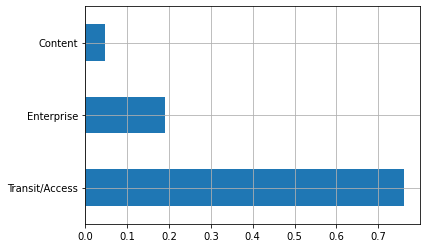

In [93]:
AS_dataset["label"].value_counts(normalize=True).plot(kind='barh', grid=True)

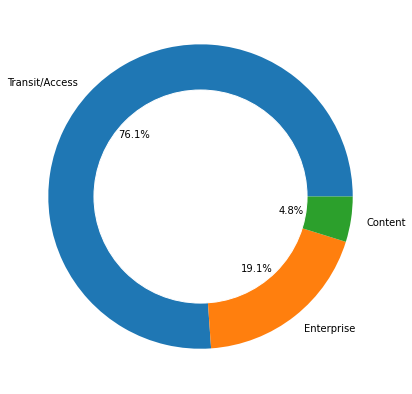

In [94]:
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(AS_dataset['label'].value_counts(), labels=['Transit/Access', 'Enterprise', 'Content'],autopct='%1.1f%%')
fig = plt.gcf()
fig.gca().add_artist(my_circle)
fig.set_size_inches(7,7)
plt.show()

In [95]:
AS_dataset.head(10)

,ASN,source_label,label
0,1,CAIDA_class,Transit/Access
1,2,CAIDA_class,Transit/Access
2,3,CAIDA_class,Transit/Access
3,4,CAIDA_class,Transit/Access
4,5,CAIDA_class,Enterprise
5,6,CAIDA_class,Content
6,7,CAIDA_class,Enterprise
7,8,CAIDA_class,Transit/Access
8,9,CAIDA_class,Transit/Access
9,10,CAIDA_class,Transit/Access


In [96]:
def dictiongraph(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(sorted(list(set(dictio))), l))
    return dictiofinal

In [97]:
def creation_graph(fichier_texte):
    G = nx.Graph() 
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= str(asn1) + '|p2p|' +str(asn2))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=str(asn1) + '|p2c|' +str(asn2))
        except ValueError:
            pass
    return G

In [98]:
G = creation_graph(FILE_PATH)

In [99]:
def creation_graph_dirige(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                
        except ValueError:
            pass
    return G

In [100]:
G_directed = creation_graph_dirige(FILE_PATH)

In [101]:
def creation_graph_dirige_inverse(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn2],dictio[asn1],type= 3/3)
                
        except ValueError:
            pass
    return G

In [102]:
G_directed_inverse = creation_graph_dirige_inverse(FILE_PATH)

In [103]:
def label_into_int(label):
    if (label == 'Content'):
        int_label = 0
    elif (label == 'Transit/Access'):
        int_label = 1
    elif (label == 'Enterprise'):
        int_label = 2
    return int_label

In [104]:
def creation_graph_float(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        #print("G add node : index " + str(i) + ", asn : " + str(num_as) + ", " + AS_dataset['label'][i] + " => " + str(label_into_int(AS_dataset['label'][i])))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 1/3)
        except ValueError:
            pass
    return G

In [105]:
G_float =creation_graph_float(FILE_PATH)

In [106]:
def creation_graph_array(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= np.array([0,1,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type= np.array([0,1,0]))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=np.array([1,0,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type=np.array([0,0,1]))
        except ValueError:
            pass
    return G

In [107]:
G_array=creation_graph_array(FILE_PATH)

In [108]:
nb_nodes_graph = G.number_of_nodes()
nb_edges_graph = G.number_of_edges()

print("Graph number of nodes :   "  + str(nb_nodes_graph))
print("Graph number of edges :  " + str(nb_edges_graph))

assert(nb_nodes_graph == int(nb_nodes_of_file(FILE_PATH)))
print("\nASSERT NB NODES OK")

Graph number of nodes :   71434
Graph number of edges :  489716

ASSERT NB NODES OK


- ### Ajout des colonnes `page_rank_not_directed`, `page_rank_directed` et `degree_centrality`

In [109]:
list_pageRank = nx.pagerank(G).values()
list_pageRank_directed = nx.pagerank(G_directed).values()
list_pageRank_directed_inverse = nx.pagerank(G_directed_inverse).values()
list_degreeCentrality = nx.degree_centrality(G).values()

- #### Scale de la donnée `page_rank_not_directed`

In [167]:
AS_dataset['page_rank_not_directed'] = list_pageRank

count    71434.000000
mean         0.000014
std          0.000106
min          0.000002
25%          0.000004
50%          0.000005
75%          0.000007
max          0.010813
Name: page_rank_not_directed, dtype: float64


Text(0, 0.5, '%')

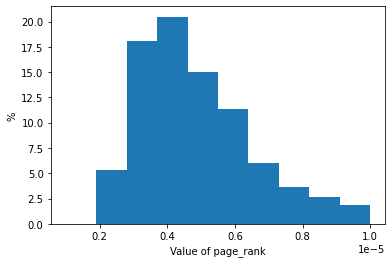

In [112]:
print(AS_dataset['page_rank_not_directed'].describe())

plt.hist(AS_dataset['page_rank_not_directed'], 
         range=(1e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_not_directed']))/len(AS_dataset['page_rank_not_directed'])))
plt.xlabel("Value of page_rank")
plt.ylabel("%")

In [118]:
AS_dataset['page_rank_not_directed'] = [element * 20000 if element * 20000 <= 1 else 1 for element in list_pageRank]

count    71434.000000
mean         0.163160
std          0.195769
min          0.046870
25%          0.075614
50%          0.098458
75%          0.141052
max          1.000000
Name: page_rank_not_directed, dtype: float64


Text(0, 0.5, '%')

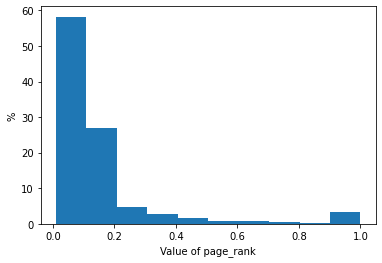

In [120]:
print(AS_dataset['page_rank_not_directed'].describe())

plt.hist(AS_dataset['page_rank_not_directed'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['page_rank_not_directed']))/len(AS_dataset['page_rank_not_directed'])))
plt.xlabel("Value of page_rank")
plt.ylabel("%")

- #### Scale de la donnée `page_rank_directed`

In [168]:
AS_dataset['page_rank_directed'] = list_pageRank_directed

count    71434.000000
mean         0.000014
std          0.000066
min          0.000008
25%          0.000009
50%          0.000009
75%          0.000011
max          0.009921
Name: page_rank_directed, dtype: float64


Text(0, 0.5, '%')

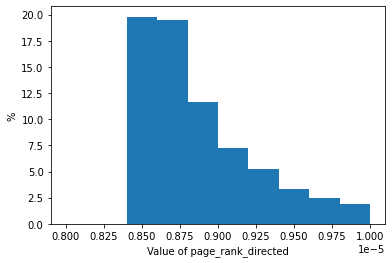

In [122]:
print(AS_dataset['page_rank_directed'].describe())

plt.hist(AS_dataset['page_rank_directed'], 
         range=(8e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed']))/len(AS_dataset['page_rank_directed'])))
plt.xlabel("Value of page_rank_directed")
plt.ylabel("%")

In [123]:
AS_dataset['page_rank_directed'] = [element * 45000 if element * 45000 <=1 else 1 for element in list_pageRank_directed]

count    71434.000000
mean         0.484493
std          0.172892
min          0.378938
25%          0.388982
50%          0.404204
75%          0.473491
max          1.000000
Name: page_rank_directed, dtype: float64


Text(0, 0.5, '%')

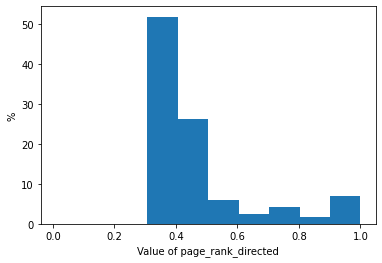

In [124]:
print(AS_dataset['page_rank_directed'].describe())

plt.hist(AS_dataset['page_rank_directed'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed']))/len(AS_dataset['page_rank_directed'])))
plt.xlabel("Value of page_rank_directed")
plt.ylabel("%")

- #### Scale de la donnée `page_rank_directed_inverse`

In [169]:
AS_dataset['page_rank_directed_inverse'] = list_pageRank_directed_inverse

count    71434.000000
mean         0.000014
std          0.000122
min          0.000002
25%          0.000002
50%          0.000002
75%          0.000002
max          0.010811
Name: page_rank_directed_inverse, dtype: float64


Text(0, 0.5, '%')

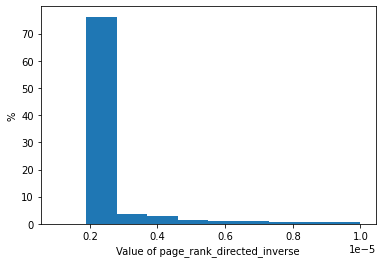

In [126]:
print(AS_dataset['page_rank_directed_inverse'].describe())

plt.hist(AS_dataset['page_rank_directed_inverse'], 
         range=(1e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed_inverse']))/len(AS_dataset['page_rank_directed_inverse'])))
plt.xlabel("Value of page_rank_directed_inverse")
plt.ylabel("%")

In [127]:
AS_dataset['page_rank_directed_inverse'] = [element * 40000 if element * 40000 <=1 else 1 for element in list_pageRank_directed_inverse]

count    71434.000000
mean         0.191827
std          0.260949
min          0.083994
25%          0.083994
50%          0.083994
75%          0.083994
max          1.000000
Name: page_rank_directed_inverse, dtype: float64


Text(0, 0.5, '%')

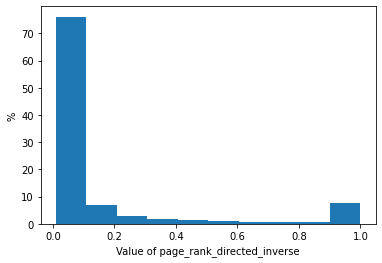

In [129]:
print(AS_dataset['page_rank_directed_inverse'].describe())

plt.hist(AS_dataset['page_rank_directed_inverse'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed_inverse']))/len(AS_dataset['page_rank_directed_inverse'])))
plt.xlabel("Value of page_rank_directed_inverse")
plt.ylabel("%")

- #### Scale de la donnée `degree_centrality`

In [170]:
AS_dataset['degree_centrality'] = list_degreeCentrality

count    71434.000000
mean         0.000192
std          0.001498
min          0.000014
25%          0.000014
50%          0.000028
75%          0.000042
max          0.127154
Name: degree_centrality, dtype: float64


Text(0, 0.5, '%')

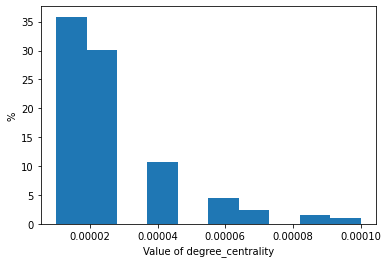

In [131]:
print(AS_dataset['degree_centrality'].describe())

plt.hist(AS_dataset['degree_centrality'], 
         range=(1e-5,1e-4), 
         weights=100*(np.ones(len(AS_dataset['degree_centrality']))/len(AS_dataset['degree_centrality'])))
plt.xlabel("Value of degree_centrality")
plt.ylabel("%")

In [132]:
AS_dataset['degree_centrality'] = [element * 10000 if element * 10000 <=1 else 1 for element in list_degreeCentrality]

count    71434.000000
mean         0.382925
std          0.296410
min          0.139991
25%          0.139991
50%          0.279983
75%          0.419974
max          1.000000
Name: degree_centrality, dtype: float64


Text(0, 0.5, '%')

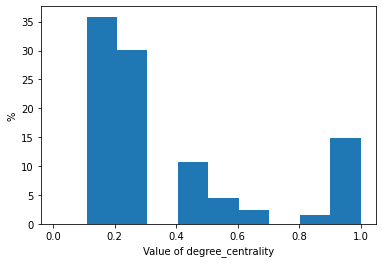

In [133]:
print(AS_dataset['degree_centrality'].describe())

plt.hist(AS_dataset['degree_centrality'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['degree_centrality']))/len(AS_dataset['degree_centrality'])))
plt.xlabel("Value of degree_centrality")
plt.ylabel("%")

In [171]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider,degree
0,1,CAIDA_class,Transit/Access,0.000025,0.000082,0.000017,0.000196,1.000000,1.000000,1.000000,1.000000,14.0
1,2,CAIDA_class,Transit/Access,0.000034,0.000162,0.000004,0.000294,1.000000,0.693147,1.000000,1.000000,21.0
2,3,CAIDA_class,Transit/Access,0.000031,0.000067,0.000092,0.000280,1.000000,1.000000,0.693147,1.000000,20.0
3,4,CAIDA_class,Transit/Access,0.000028,0.000093,0.000004,0.000210,1.000000,1.000000,0.693147,1.000000,15.0
4,5,CAIDA_class,Enterprise,0.000016,0.000126,0.000004,0.000098,0.845098,1.000000,0.000000,0.778151,7.0


In [135]:
def dictiongraph_Nbnoeud_Asn(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(l, sorted(list(set(dictio)))))
    return dictiofinal
Dictio_noeud_as = dictiongraph_Nbnoeud_Asn(FILE_PATH)

In [136]:
def nbtypevoisins2(G):
    nbNoeuds = G.number_of_nodes()
    Liste_Nb_Voisins_Peering = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Customer = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Provider = np.zeros(nbNoeuds)
    for i in range(nbNoeuds):
        for j in range(len(G[i])) :
            infos = list(G[i].values())[j]["type"].split("|")
            #print(infos)
            type_lien = infos[1]
            if type_lien == "p2p":

                Liste_Nb_Voisins_Peering[i] +=1
                #Liste_Nb_Voisins_Peering[dictio_as_noeud[int(asn2)]] +=1
            elif type_lien == "p2c":
                asn1 = infos[0]
                asn2 = infos[2]
                if int(asn2) == int(Dictio_noeud_as[i]) :
                     Liste_Nb_Voisins_Provider[i]+=1                
                else :
                    Liste_Nb_Voisins_Customer[i]+=1

        #print(i)

    return Liste_Nb_Voisins_Peering, Liste_Nb_Voisins_Customer, Liste_Nb_Voisins_Provider 
                
#### TEMPS D'EXECUTION : 5min ~
L1,L2,L3=nbtypevoisins2(G) 

- ### Vérification de la conformité des listes L1, L2 et L3 par rapport au graphe

In [137]:
max_degree_list = max(L1 + L2 + L3)
highest_degree_graph = max(list(dict(G.degree()).values()))
index_max = list(dict(G.degree()).values()).index(highest_degree_graph)
ASN_max = list(Dictio_noeud_as.values())[index_max]

print("Max degree list : "  + str(max_degree_list))
print("Max degree index : " + str(index_max) + ", max degree ASN : " + str(ASN_max))
print("Max degree graph : " + str(highest_degree_graph))

assert (max_degree_list == highest_degree_graph)
print("\nASSERT MAX DEGREE OK")

Max degree list : 9083.0
Max degree index : 2475, max degree ASN : 6939
Max degree graph : 9083

ASSERT MAX DEGREE OK


In [138]:
# Extraction des maximum de p2p link, customer link et provider link
max_p2p, index_max_p2p = np.max(L1), np.argmax(L1)
max_c,   index_max_c   = np.max(L2), np.argmax(L2)
max_p,   index_max_p   = np.max(L3), np.argmax(L3)

print("Max p2p links          : " + str(max_p2p) + ", index : " + str(index_max_p2p) + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p2p]))
print("Max nb customer links  : " + str(max_c)   + ", index : " + str(index_max_c)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_c]))
print("Max nb provider links  : " + str(max_p)   + ", index : " + str(index_max_p)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p]))

Max p2p links          : 7250.0, index : 2475, ASN : 6939
Max nb customer links  : 6237.0, index : 107, ASN : 174
Max nb provider links  : 137.0, index : 11176, ASN : 20940


In [61]:
AS_dataset.iloc[index_max_p2p]

ASN                                     6939
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed               0.00835
page_rank_directed                  0.009921
page_rank_directed_inverse          0.010811
degree_centrality                   0.127154
Name: 2475, dtype: object

In [62]:
AS_dataset.iloc[index_max_c]

ASN                                      174
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed              0.010813
page_rank_directed                  0.000129
page_rank_directed_inverse          0.009297
degree_centrality                   0.088964
Name: 107, dtype: object

In [63]:
AS_dataset.iloc[index_max_p]

ASN                                  20940
source_label                  peerDB_class
label                              Content
page_rank_not_directed            0.000541
page_rank_directed                0.000361
page_rank_directed_inverse        0.000734
degree_centrality                 0.013271
Name: 11176, dtype: object

- ### Ajout de la colonne `degree_normalized` définit par le log du degré de chaque noeud

In [172]:
## a supprimer

List_degree = L1 + L2 + L3

AS_dataset['degree_normalized'] = List_degree

In [165]:
List_degree = L1 + L2 + L3

AS_dataset['degree_normalized'] = [np.log10(element) if np.log10(element)<=1 else 1 for element in List_degree]

In [173]:
AS_dataset['degree_normalized'].describe()

count    71434.000000
mean        13.711006
std        107.017415
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       9083.000000
Name: degree_normalized, dtype: float64

In [166]:
AS_dataset['degree_normalized'].value_counts()

0.000000    25598
0.301030    21540
1.000000     8684
0.477121     7631
0.602060     3230
0.698970     1743
0.778151     1064
0.845098      781
0.903090      640
0.954243      523
Name: degree_normalized, dtype: int64

In [174]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider,degree
0,1,CAIDA_class,Transit/Access,0.000025,0.000082,0.000017,0.000196,14.0,1.000000,1.000000,1.000000,14.0
1,2,CAIDA_class,Transit/Access,0.000034,0.000162,0.000004,0.000294,21.0,0.693147,1.000000,1.000000,21.0
2,3,CAIDA_class,Transit/Access,0.000031,0.000067,0.000092,0.000280,20.0,1.000000,0.693147,1.000000,20.0
3,4,CAIDA_class,Transit/Access,0.000028,0.000093,0.000004,0.000210,15.0,1.000000,0.693147,1.000000,15.0
4,5,CAIDA_class,Enterprise,0.000016,0.000126,0.000004,0.000098,7.0,1.000000,0.000000,0.778151,7.0


- ### Ajout des colonnes `ratio_peering`, `ratio_customer` et `ratio_provider`

In [175]:
## a supprimmer

AS_dataset['ratio_peering']  = L1

AS_dataset['ratio_customer'] = L2

AS_dataset['ratio_provider'] = L3

In [147]:
AS_dataset['ratio_peering']  = [np.log(element+1) if np.log(element+1)<=1 else 1 for element in L1]

AS_dataset['ratio_customer'] = [np.log(element+1) if np.log(element+1)<=1 else 1 for element in L2]

AS_dataset['ratio_provider'] = [np.log10(element+1) if np.log10(element+1)<=1 else 1 for element in L3]

In [148]:
print(AS_dataset['ratio_peering'].value_counts())
print(AS_dataset['ratio_customer'].value_counts())
print(AS_dataset['ratio_provider'].value_counts())

0.000000    58900
1.000000     9845
0.693147     2689
Name: ratio_peering, dtype: int64
0.000000    60531
1.000000     6474
0.693147     4429
Name: ratio_customer, dtype: int64
0.301030    29226
0.477121    25250
0.602060     9225
0.698970     3651
0.778151     1612
0.845098      787
1.000000      596
0.000000      425
0.903090      384
0.954243      278
Name: ratio_provider, dtype: int64


In [149]:
AS_dataset['ratio_peering'].describe()

count    71434.000000
mean         0.163912
std          0.359221
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ratio_peering, dtype: float64

In [118]:
AS_dataset['ratio_customer'].describe()

count    71434.000000
mean         0.228704
std          0.677011
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.738415
Name: ratio_customer, dtype: float64

In [119]:
AS_dataset['ratio_provider'].describe()

count    71434.000000
mean         0.450143
std          0.164351
min          0.000000
25%          0.301030
50%          0.477121
75%          0.477121
max          2.139879
Name: ratio_provider, dtype: float64

In [151]:
AS_dataset[550:558]

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
550,1536,CAIDA_class,Transit/Access,0.129544,0.770263,0.905408,0.139991,0.000000,0.693147,0.000000,0.00000
551,1537,CAIDA_class,Transit/Access,0.125810,0.393434,0.083994,0.139991,0.000000,0.000000,0.000000,0.30103
552,1538,CAIDA_class,Transit/Access,0.221632,0.838601,1.000000,0.279983,0.301030,1.000000,0.000000,0.00000
553,1539,manual_class,Enterprise,0.389131,0.770263,1.000000,0.419974,0.477121,0.693147,1.000000,0.00000
554,1540,CAIDA_class,Content,0.218260,0.770263,1.000000,0.279983,0.301030,0.693147,0.693147,0.00000
555,1541,CAIDA_class,Transit/Access,1.000000,0.770263,1.000000,1.000000,1.000000,0.693147,1.000000,0.00000
556,1547,peerDB_class,Transit/Access,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
557,1551,CAIDA_class,Transit/Access,0.127189,0.430431,0.083994,0.139991,0.000000,0.000000,0.000000,0.30103


In [68]:
AS_dataset [AS_dataset['ASN'] == 6939]

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
2475,6939,peerDB_class,Transit/Access,0.00835,0.009921,0.010811,0.127154,9083.0,7250.0,1831.0,2.0


In [69]:
index_max_p2p = AS_dataset.index [AS_dataset['ASN'] == 6939]
print("Nb p2p : " + str(int(L1[index_max_p2p]))
      + "\nNb c   : " + str(int(L2[index_max_p2p])) 
      + "\nNb p   : " + str(int(L3[index_max_p2p])))

Nb p2p : 7250
Nb c   : 1831
Nb p   : 2


In [ ]:
#AS_dataset['peering_links']  = L1
#AS_dataset['customer_links'] = L2
#AS_dataset['provider_links'] = L3

#AS_dataset['peering_links_mal_scaled']    = AS_dataset['peering_links']/max_p2p
#AS_dataset['customer_links_mal_scaled']   = AS_dataset['customer_links']/max_c
#AS_dataset['provider_links_mal_scaled']   = AS_dataset['provider_links']/max_p

#AS_dataset['peering_centre_reduit']  = sklearn.preprocessing.scale(AS_dataset['peering_links'])
#AS_dataset['customer_centre_reduit'] = sklearn.preprocessing.scale(AS_dataset['customer_links'])
#AS_dataset['provider_centre_reduit'] = sklearn.preprocessing.scale(AS_dataset['provider_links'])

In [ ]:
AS_dataset['peering_links'].describe()

In [ ]:
AS_dataset['customer_links'].describe()

In [ ]:
AS_dataset['provider_links'].describe()

In [ ]:
AS_dataset['peering_centre_reduit'].describe()

In [ ]:
AS_dataset['peering_centre_reduit'].quantile(0.99)

In [ ]:
AS_dataset['customer_centre_reduit'].describe()

In [ ]:
AS_dataset['provider_centre_reduit'].describe()

In [ ]:
AS_dataset['peering_links_mal_scaled'].describe()

In [ ]:
AS_dataset['customer_links_mal_scaled'].describe()

In [ ]:
AS_dataset['provider_links_mal_scaled'].describe()

In [ ]:
AS_dataset['peering_links_mal_scaled'].value_counts()

In [ ]:
AS_dataset['customer_links'].describe()

In [ ]:
AS_dataset['provider_links'].describe()

In [ ]:
AS_dataset['peering_links'] = L1/max_p2p
AS_dataset['customer_links'] = L2/max_c
AS_dataset['provider_links'] = L3/max_p

assert(AS_dataset['peering_links'][index_max_p2p] == 1)
assert(AS_dataset['customer_links'][index_max_c] == 1)
assert(AS_dataset['provider_links'][index_max_p] == 1)

In [176]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider,degree
0,1,CAIDA_class,Transit/Access,0.000025,0.000082,0.000017,0.000196,14.0,2.0,2.0,10.0,14.0
1,2,CAIDA_class,Transit/Access,0.000034,0.000162,0.000004,0.000294,21.0,1.0,2.0,18.0,21.0
2,3,CAIDA_class,Transit/Access,0.000031,0.000067,0.000092,0.000280,20.0,5.0,1.0,14.0,20.0
3,4,CAIDA_class,Transit/Access,0.000028,0.000093,0.000004,0.000210,15.0,2.0,1.0,12.0,15.0
4,5,CAIDA_class,Enterprise,0.000016,0.000126,0.000004,0.000098,7.0,2.0,0.0,5.0,7.0


- ### Modification de la colonne `label`

On transforme la **catégorie non ordinale** en 3 classes entières :
 - *Content* ⇔ $0$
 - *Transit/Access* ⇔ $1$
 - *Enterprise* ⇔ $2$

In [124]:
AS_dataset['label'] = AS_dataset['label'].map({'Content': 0, 'Transit/Access': 1, 'Enterprise': 2})

In [168]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
0,1,CAIDA_class,1,0.500388,3.688530,0.675913,1.959878,1.146128,1.098612,1.098612,1.041393
1,2,CAIDA_class,1,0.687322,7.292742,0.169510,2.939818,1.322219,0.693147,1.098612,1.278754
2,3,CAIDA_class,1,0.623851,2.997638,3.691148,2.799826,1.301030,1.791759,0.693147,1.176091
3,4,CAIDA_class,1,0.569730,4.188328,0.155139,2.099870,1.176091,1.098612,0.693147,1.113943
4,5,CAIDA_class,2,0.319572,5.659595,0.142545,0.979939,0.845098,1.098612,0.000000,0.778151


### Exportation des données : `dataset` et `graph`

On crée 4 fichiers : 
- Le `dataset`complet 
- Le `graphe` nx au format pickle
- Le `graphe_float` nx au format pickle
- Le `graphe_array` nx au format pickle

In [152]:
# Exportation des données

suffix = FILE_PATH.split('/')[3].split('.')[0]

AS_dataset.to_csv('data_GCN/dataset_v5_'+suffix+'.csv', index=False)
nx.write_gpickle(G, 'data_GCN/graph_'+suffix+'.pickle')
nx.write_gpickle(G_float, 'data_GCN/graph_float_'+suffix+'.pickle')
nx.write_gpickle(G_array, 'data_GCN/graph_array_'+suffix+'.pickle')